In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

project_root = Path.cwd().parent  
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))


from src.utils.snotel_utils import SNOTEL
from src.data_preprocessing.process_modis import ModisDataProcessor

## Domain

In [2]:
path_to_geog = '/bsuscratch/stanleyakor/uppercolorado/static_inputs/wrfout_d02_2000-04-08_00:00:00'
path_to_header = '/bsuscratch/stanleyakor/uppercolorado/ml_frameworks/evaluation/DOWNLOAD_SNOTEL/NRCS_SNOTEL_Locations_noAlaska.csv'
path_to_csv = '/bsuscratch/stanleyakor/uppercolorado/ml_frameworks/evaluation/DOWNLOAD_SNOTEL/snotel_data/'

In [3]:
snotel_routine =  SNOTEL(var = 'SNOW',\
                 path_to_header = path_to_header,\
                 path_to_csv = path_to_csv ,\
                 path_to_geog =None,\
                 path_to_wrf_file = None,\
                 start =  None,\
                 end =  None)

In [4]:
lat,lon,_,_,elevation = snotel_routine.collect_snotel_info()

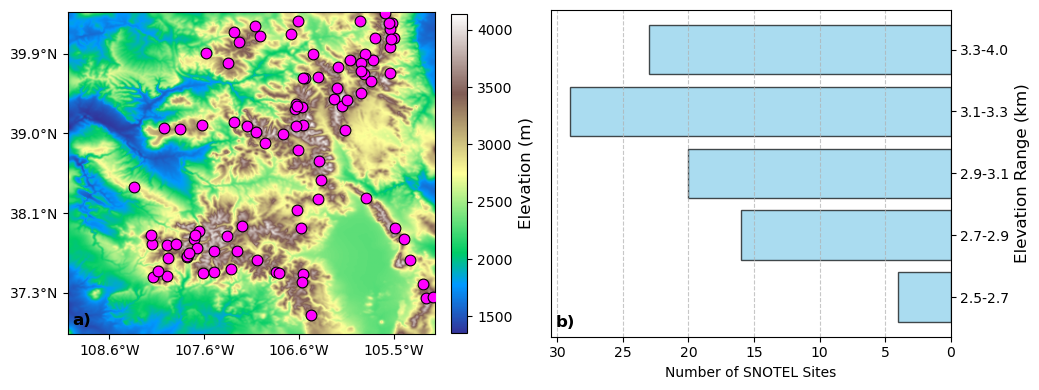

In [5]:


fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10.5, 4))  


for la, lo in zip(lat, lon):
    ax0.scatter(lo, la, marker='o', s=60, color='magenta', edgecolor='black', linewidth=0.8, zorder=5)

# Plot 1: Domain topography
geog = xr.open_dataset(path_to_geog)
im = ax0.imshow(geog['HGT'].sel(Time=0), extent=(geog.XLONG.min(), geog.XLONG.max(), geog.XLAT.min(), geog.XLAT.max()),
                cmap='terrain', origin='lower', alpha=1.)

diff = 0.45 

ax0.set_xticks(np.linspace(geog.XLONG.min().values + diff, geog.XLONG.max().values - diff, 4))
ax0.set_yticks(np.linspace(geog.XLAT.min().values + diff, geog.XLAT.max().values - diff, 4))

lon_ticks = ax0.get_xticks()
lat_ticks = ax0.get_yticks()

lon_labels = [f'{abs(lon):.1f}°{"W" if lon < 0 else "E"}' for lon in lon_ticks]
lat_labels = [f'{abs(lat):.1f}°{"S" if lat < 0 else "N"}' for lat in lat_ticks]

ax0.set_xticklabels(lon_labels)
ax0.set_yticklabels(lat_labels)

cbar = fig.colorbar(im, ax=ax0, fraction=0.04, pad=0.04)
cbar.set_label('Elevation (m)',fontsize=12)


ax0.text(0.01, 0.03, 'a)', transform=ax0.transAxes, fontsize=12, color='black', weight='bold')

# Plot 2: Categorized elevation distribution (horizontal bar chart)
bins = [2500, 2700, 2900, 3100, 3300,4000]
categories = [f"{bins[i]/1e3}-{bins[i+1]/1e3}" for i in range(len(bins)-1)]


hist, _ = np.histogram((1/3.281)*np.array(elevation), bins=bins)


ax1.barh(categories, hist, color='skyblue', edgecolor='black', alpha=0.7)


ax1.invert_xaxis()


ax1.set_xlabel('Number of SNOTEL Sites')
ax1.set_ylabel('Elevation Range (km)',fontsize=12)
ax1.yaxis.set_label_position('right') 

ax1.tick_params(axis='y', left=False, labelleft=False, right=True, labelright=True)


ax1.text(0.01, 0.03, 'b)', transform=ax1.transAxes, fontsize=12, color='black', weight='bold')

ax1.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# MODIS SNOW COVER

In [6]:
processor = ModisDataProcessor(
    snow_pattern="/bsuscratch/stanleyakor/swe_emulator/modis/snowcover/*",
    cloud_pattern="/bsuscratch/stanleyakor/swe_emulator/modis/cloud/*",
    output_file="snow_data.nc",
    ideal_shape=(390, 348),
    cloud_threshold=35
)

Initialized SnowDataProcessor with cloud threshold 35%


In [7]:
ds = processor.convert_tif_netcdf()

NetCDF file created: snow_data.nc


In [8]:
ds['XTIME'] = xr.decode_cf(ds).XTIME  
ds['time'] = xr.DataArray(pd.to_datetime(ds['XTIME'].values), dims='XTIME')
ds = ds.swap_dims({'XTIME': 'time'})  


monthly_climatology = ds['snow_cover'].groupby('time.month').mean(dim='time')  


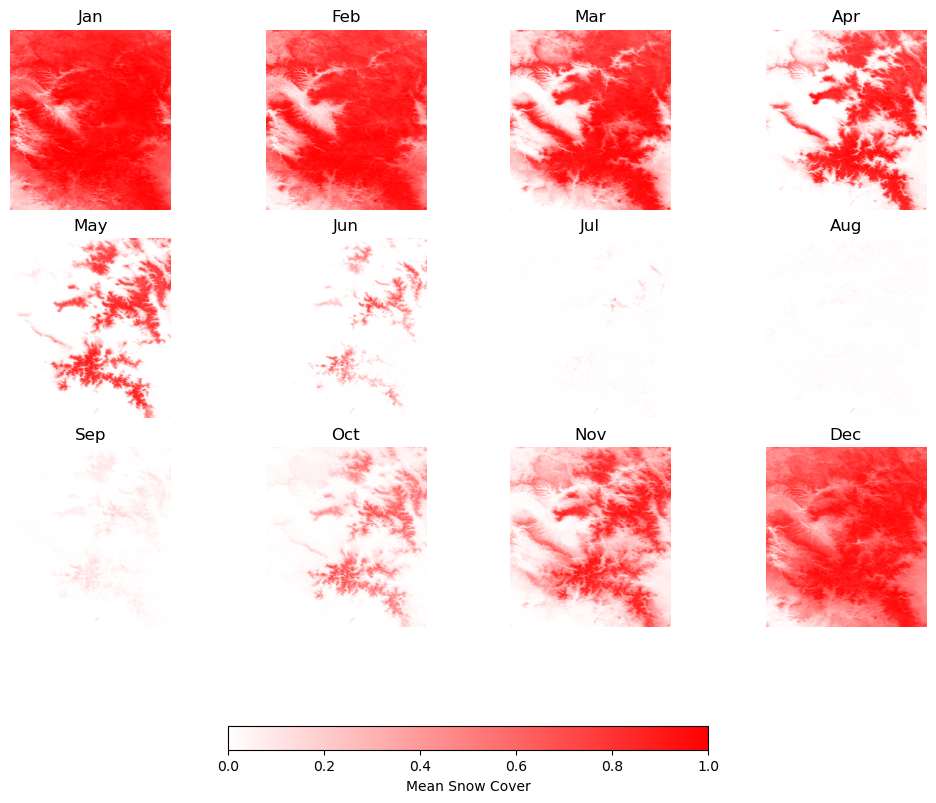

In [9]:
red_white_cmap = LinearSegmentedColormap.from_list(
    "red_white_cmap", ["white","red"]
)



fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 8), constrained_layout=True)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for i, ax in enumerate(axes.flat):
    im = ax.imshow(monthly_climatology[i, :, :], cmap=red_white_cmap, vmin=0, vmax=1)
    ax.set_title(months[i])
    ax.axis('off')


cbar = fig.colorbar(
    im, ax=axes[:, 1:3], orientation='horizontal', fraction=0.08, pad=0.15
)

cbar.set_label('Mean Snow Cover')
plt.show()
